# Loading recent Sentinel-2 data using STAC


In [1]:
import pystac_client
import odc.stac
from datetime import datetime, timedelta

# Connect to the DEA Explorer STAC API to allow searching for data
client = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")

# To load data via STAC, we must configure appropriate access to data stored on
# DEA’s Amazon S3 buckets. This can be done with the odc.stac.configure_rio function.
# The configuration below must be used when loading any DEA data through the STAC API.
odc.stac.configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
)

## Configure analysis

In [2]:
# Set spatial bounding box to load
bbox = [131.231, -12.82881, 131.48509, -13.08704]

# Set number of days to look back through time
time_window = 7

# Bands to load
bands = ["nbart_swir_2", "nbart_swir_3"]   # ["nbart_red", "nbart_green", "nbart_blue"] 

## Search for data

In [3]:
# Calculate time query
end = datetime.now()
start = end - timedelta(days=time_window)
time = f"{start:%Y-%m-%d}/{end:%Y-%m-%d}"

# Search for STAC items
query = client.search(
    collections=["ga_s2am_ard_3", "ga_s2bm_ard_3"],
    bbox=bbox,
    datetime=time,
)
items = list(query.items())
print(f"Timesteps found: {[i.properties['datetime'] for i in items]}")

Timesteps found: ['2024-08-21T01:40:58.432774Z', '2024-08-23T01:30:59.955037Z', '2024-08-26T01:40:56.051477Z']


## Load data

In [4]:
# lazy load into xarray
ds = odc.stac.load(
    items,
    bbox=bbox,
    measurements=bands,
    groupby="solar_day",
    chunks={"x": 2048, "y": 2048},
)

### Calculate index

In [5]:
# Normalise between 0 and 1
ds = ds * 0.0001

# Calculate index
mirbi = 10.0 * ds.nbart_swir_2 - 9.8 * ds.nbart_swir_2 + 2.0

# Load into memory
mirbi.load()

<xarray.DataArray 'nbart_swir_2' (time: 3, y: 1443, x: 1393)> Size: 24MB
array([[[2.02772  , 2.03538  , 2.04754  , ..., 2.0520802, 2.05372  ,
         2.05452  ],
        [2.0327   , 2.04118  , 2.0495799, ..., 2.05354  , 2.05808  ,
         2.06102  ],
        [2.03736  , 2.0439   , 2.0470798, ..., 2.05964  , 2.0627398,
         2.06388  ],
        ...,
        [2.08318  , 2.08396  , 2.0854397, ..., 2.06974  , 2.0692198,
         2.0693398],
        [2.072    , 2.07918  , 2.07668  , ..., 2.0690198, 2.06962  ,
         2.07032  ],
        [2.06798  , 2.06966  , 2.06756  , ..., 2.0692198, 2.07036  ,
         2.07054  ]],

       [[      nan,       nan,       nan, ..., 2.05218  , 2.05478  ,
         2.05678  ],
        [      nan,       nan,       nan, ..., 2.0552402, 2.0599802,
         2.0627398],
        [      nan,       nan,       nan, ..., 2.06128  , 2.06464  ,
         2.06382  ],
...
        [      nan,       nan,       nan, ..., 2.0698   , 2.0690799,
         2.06952  ],
        [      nan,       nan,       nan, ..., 2.06964  , 2.0699599,
         2.07002  ],
        [      nan,       nan,       nan, ..., 2.06864  , 2.06998  ,
         2.0700998]],

       [[2.02652  , 2.0359201, 2.04888  , ..., 2.05264  , 2.05536  ,
         2.05634  ],
        [2.0314999, 2.0426798, 2.05048  , ..., 2.05492  , 2.06026  ,
         2.06106  ],
        [2.0386   , 2.0457602, 2.0482798, ..., 2.0606399, 2.06404  ,
         2.0628   ],
        ...,
        [2.08184  , 2.08328  , 2.08498  , ..., 2.06944  , 2.06918  ,
         2.06984  ],
        [2.07344  , 2.0764399, 2.07618  , ..., 2.06928  , 2.06914  ,
         2.0699599],
        [2.06914  , 2.06974  , 2.0709798, ..., 2.06872  , 2.07028  ,
         2.0701602]]], dtype=float32)
Coordinates:
  * y            (y) float64 12kB 8.581e+06 8.581e+06 ... 8.552e+06 8.552e+06
  * x            (x) float64 11kB 7.419e+05 7.419e+05 ... 7.697e+05 7.698e+05
    spatial_ref  int32 4B 32752
  * time         (time) datetime64[ns] 24B 2024-08-21T01:40:58.432774 ... 202...

## Visualise and export

In [6]:
# Explore the most recent imagery on a map
mirbi.isel(time=-1).odc.explore(robust=True)

In [7]:
# Save most recent image to file
mirbi.isel(time=1).odc.write_cog("mirbi.tif", overwrite=True)

PosixPath('mirbi.tif')

### Optional: create mosaic of recent imagery

In [8]:
mirbi_median = mirbi.median(dim="time")

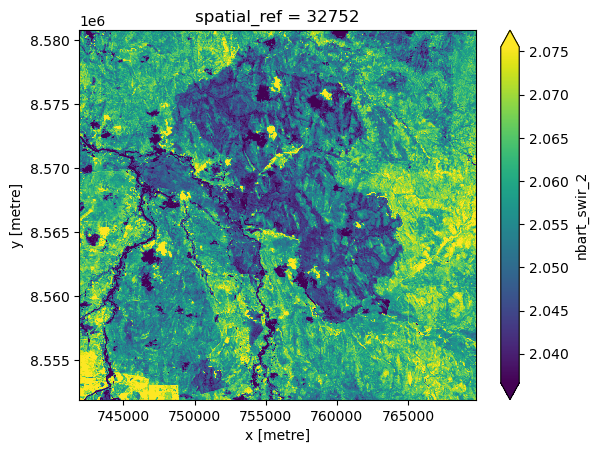

In [9]:
mirbi_median.plot.imshow(robust=True)

## Download directly from STAC

Allows downloading raw files without loading them into `xarray` format first: https://stac-asset.readthedocs.io/en/stable/

In [10]:
# pip install stac-asset

In [11]:
import stac_asset

In [12]:
# Search for STAC items
query = client.search(
    collections=["ga_s2am_ard_3", "ga_s2bm_ard_3"],
    bbox=bbox,
    datetime=time,
)

config = stac_asset.Config(include=bands, overwrite=True, s3_requester_pays=True)
await stac_asset.download_item_collection(
    item_collection=query.item_collection(), directory=".", config=config
)